In This notebook, we will do EDA  


maybe later we will do this

This is base frameworks used:
 - Electra (Clark et al., 2020) 
 - BERT (Devlin et al., 2019),


in our dataframe Embedding:
- AraELECTRA (Antoun et al., 2021)    -> electra 
- AraBERTv2 (Antoun et al., 2020)     ->  bertseg
- camelBERT-MSA (Inoue et al., 2021)  -> bertmsa
#


https://groups.google.com/g/sigarab/c/8e3Os4Q0Aac
Task 1: Reverse Dictionary (RD)

RDs, identified by their sequence-to-vector format, characterized as sequence-to-vector, introduce a differentiated strategy in contrast to traditional dictionary lookup methods. The RD task concentrates on the conversion of human-readable glosses into word embedding vectors.

This process entails reconstructing the word embedding vector corresponding to the defined word, a methodology aligning with the approaches of (Mickus et al., 2022; Zanzotto et al., 2010; Hill et al., 2016). 

The dataset includes, lemma, lemma vector representations, and their respective gloss. 

The developed model is expected to generate novel lemma vector representations for the unseen human-readable definitions in the test set. Such a strategy allows users to search for words based on anticipated definitions or meanings.



Datasets:

Datasets can be downloaded from CODALAB-Task1 and  CODALAB-Task2. This section details the structure of the JSON dataset files provided.

Task 1: RD:

The dataset itself comprises two core components: the dictionary data and the word embedding vectors.

In the first iteration of KSAA-RD (Al-Matham et al., 2023), the dataset derived from a single source: the "Contemporary Arabic Language Dictionary" by Ahmed Mokhtar Omar (Omar, 2008). In this revised edition, we endeavor to expand our sources to encompass three dictionaries of Contemporary Arabic Language. The first of these is the "Contemporary Arabic Language Dictionary" by Ahmed Mokhtar Omar (Omar, 2008), a resource previously utilized in the first iteration KSAA-RD. The second is the newly released dictionary of the Arabic contemporary language "Mu'jam Arriyadh" (Altamimi et al., 2023). The third is the "Al Wassit LMF Arabic Dictionary" (Namly, 2015).

These dictionaries comprise words, commonly referred to as lemmas, and these may come with glosses, part of speech (POS), and examples. 

In the generation of these word embeddings, our approach is to utilize three distinct architectures of contextualized word embedding, such as Electra (Clark et al., 2020) and BERT (Devlin et al., 2019), to enhance the effectiveness of the system. Specifically, we employ AraELECTRA (Antoun et al., 2021), AraBERTv2 (Antoun et al., 2020), and camelBERT-MSA (Inoue et al., 2021) —referred to respectively as electra, bertseg, and bertmsa—for our methodologies. 

As a concrete instance, here is an example from the training dataset for the Arabic dictionary: 

{

"id":"ar.45",

"word":"عين",

"gloss":"عضو الإبصار في ...",

"pos":"n",

"electra":[0.4, 0.3, …],

"bertseg":[0.7, 2.9, …],

"bertmsa":[0.8, 1.4, …],

 }



The base line here !!!!
https://github.com/ksaa-nlp/KSAA-CAD
https://arai.ksaa.gov.sa/sharedTask2024/

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


# from arabic_reshaper import arabic_reshaper
# from bidi.algorithm import get_display

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from transformers import AutoTokenizer, AutoModel

In [ ]:
with open('dev.json', 'r', encoding='utf-8') as file:
    d = json.load(file)

# with open('train.json', 'r', encoding='utf-8') as file:
#     t = json.load(file)

# with open('test_rd.json', 'r', encoding='utf-8') as file:
#     tt = json.load(file)

data = pd.DataFrame(d)

In [1]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3921 non-null   object
 1   word     3921 non-null   object
 2   pos      3636 non-null   object
 3   gloss    3921 non-null   object
 4   electra  3921 non-null   object
 5   bertseg  3921 non-null   object
 6   bertmsa  3921 non-null   object
dtypes: object(7)
memory usage: 214.6+ KB


In [ ]:
word = data["word"].value_counts()
pos = data["pos"].value_counts()
word_pos = data[["word", "pos"]].value_counts()
# print(data["gloss"].value_counts())
# print(data["electra"].value_counts())
# print(data["bertseg"].value_counts())
# print(data["bertmsa"].value_counts())

<Axes: ylabel='pos'>

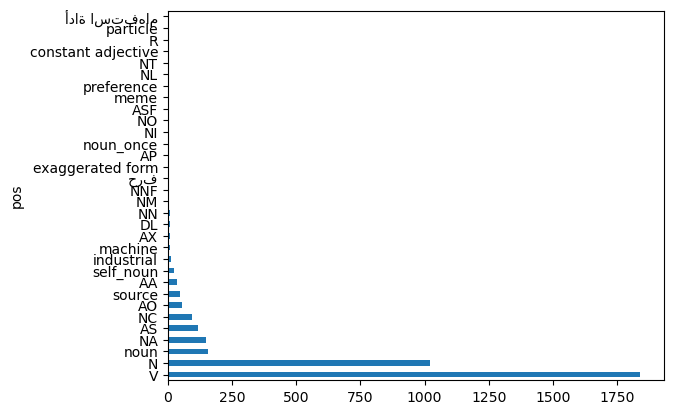

In [2]:
# word.plot(kind="barh")
# word.plot(kind="hist")
pos.plot(kind="barh")

In [3]:
machines = data[data["pos"] == "machine"]
print(machines[["word", "gloss", "pos"]])

                    word                                              gloss      pos
205              مِرْقَم  إصْبع كأصابع الطباشير مصنوعة من أصباغ ترابيَّة...  machine
295               مِدْفأ                                    موقد يستدفأ به.  machine
776            مِبْشَرَة   أداة تُستعمل في قَشر بعض الخضر والفواكه وغيره...  machine
1071              مِخْوض                       : آلة لخلط الشَّراب وتحريكه.  machine
2048              مِشْبك  أداة من خشب أو معدن أو بلاستيك يُشبك بها الشّي...  machine
2435             كَبَّاس  أداة تدفَع غاز البترول في موقده بواسطة ضغط اله...  machine
2782             مِقْلاع      أداة تُرْمَى بها الحجارةُ يستعملها الرُّعاةُ   machine
3255  مِضَخَّة الأنسولين  جهاز محمول يستخدمه مرضى السكَّر يقوم بحقن المر...  machine
3655            مِدْفََع  آلة حربيّة حديديّة تُرْمَى بها القذائفُ ولها أ...  machine
3695             مِرْقَم                                     أداة الرَّسم .  machine


# BERT Embedding
We will do like in this video for  BERT
https://www.youtube.com/watch?v=30zPz5Xz-8g
https://github.com/rohan-paul/LLM-FineTuning-Large-Language-Models/blob/main/Other-Language_Models_BERT_related/Understing_BERT_Embedding_Vector/Understing_BERT_Embedding_Vector.ipynb

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

model = BertModel.from_pretrained('bert-base-uncased')
sentence = 'She is a MachineLearning Engineer and works in California'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(sentence)

In [4]:
tokens

['she',
 'is',
 'a',
 'machine',
 '##lea',
 '##rn',
 '##ing',
 'engineer',
 'and',
 'works',
 'in',
 'california']

In [5]:
tokens = ['[CLS]'] + tokens + ['[SEP]']
print(tokens)

tokens = tokens + ['[PAD]'] + ['[PAD]']
print(len(tokens))
attention_mask = [1 if i!= '[PAD]' else 0 for i in tokens]
print(attention_mask)

['[CLS]', 'she', 'is', 'a', 'machine', '##lea', '##rn', '##ing', 'engineer', 'and', 'works', 'in', 'california', '[SEP]']
16
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


In [6]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)
print(tokens)

[101, 2016, 2003, 1037, 3698, 19738, 6826, 2075, 3992, 1998, 2573, 1999, 2662, 102, 0, 0]
['[CLS]', 'she', 'is', 'a', 'machine', '##lea', '##rn', '##ing', 'engineer', 'and', 'works', 'in', 'california', '[SEP]', '[PAD]', '[PAD]']


In [7]:
token_ids = torch.tensor(token_ids).unsqueeze(0)

attention_mask = torch.tensor(attention_mask).unsqueeze(0)
output = model(token_ids, attention_mask = attention_mask)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1925,  0.1684, -0.4252,  ..., -0.2599,  0.3736,  0.0529],
         [ 0.2417, -0.2748, -0.4909,  ...,  0.1372,  0.3408, -0.4655],
         [-0.0871,  0.0837,  0.2605,  ..., -0.4635, -0.0462,  0.2621],
         ...,
         [ 0.6711, -0.0076, -0.3847,  ..., -0.1289, -0.5171, -0.8002],
         [-0.2731,  0.1098, -0.5440,  ...,  0.0314,  0.4467, -0.3448],
         [-0.2387,  0.0119, -0.4760,  ...,  0.4656,  0.5837, -0.3774]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.9531, -0.4914, -0.8872,  0.9035,  0.8174, -0.2919,  0.9511,  0.4982,
         -0.7595, -1.0000, -0.6996,  0.9459,  0.9890,  0.4754,  0.9723, -0.8460,
         -0.1423, -0.7209,  0.4428, -0.7905,  0.7822,  1.0000,  0.2119,  0.4066,
          0.5813,  0.9923, -0.8380,  0.9670,  0.9746,  0.8324, -0.8227,  0.4136,
         -0.9931, -0.2821, -0.8860, -0.9961,  0.5261, -0.8722, -0.0915, -0.0950,
         -0.9237,  0.5106,  1.00

In [8]:
output[0].shape

torch.Size([1, 16, 768])

In [9]:
output[1]

tensor([[-0.9531, -0.4914, -0.8872,  0.9035,  0.8174, -0.2919,  0.9511,  0.4982,
         -0.7595, -1.0000, -0.6996,  0.9459,  0.9890,  0.4754,  0.9723, -0.8460,
         -0.1423, -0.7209,  0.4428, -0.7905,  0.7822,  1.0000,  0.2119,  0.4066,
          0.5813,  0.9923, -0.8380,  0.9670,  0.9746,  0.8324, -0.8227,  0.4136,
         -0.9931, -0.2821, -0.8860, -0.9961,  0.5261, -0.8722, -0.0915, -0.0950,
         -0.9237,  0.5106,  1.0000, -0.0830,  0.5382, -0.3140, -1.0000,  0.3774,
         -0.9557,  0.8998,  0.7947,  0.8279,  0.2756,  0.6581,  0.6064, -0.3369,
          0.0251,  0.1856, -0.3297, -0.7515, -0.6843,  0.4392, -0.8613, -0.9603,
          0.8838,  0.7763, -0.3041, -0.3105, -0.1854, -0.0969,  0.9726,  0.3039,
          0.0437, -0.8890,  0.6619,  0.2710, -0.7410,  1.0000, -0.5422, -0.9900,
          0.7010,  0.7629,  0.6910, -0.1635,  0.4133, -1.0000,  0.6527, -0.1595,
         -0.9959,  0.2069,  0.5956, -0.3285,  0.3339,  0.7146, -0.4482, -0.5843,
         -0.4799, -0.8426, -

In [10]:
output[1].shape

torch.Size([1, 768])

In [11]:
data.info  ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3921 non-null   object
 1   word     3921 non-null   object
 2   pos      3636 non-null   object
 3   gloss    3921 non-null   object
 4   electra  3921 non-null   object
 5   bertseg  3921 non-null   object
 6   bertmsa  3921 non-null   object
dtypes: object(7)
memory usage: 214.6+ KB


# AraBERTv2

In [ ]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/bert-base-arabertv02'

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name)

In [12]:
sentence = data["word"][0]

preprocessed = preprocessor.preprocess(sentence)
print(preprocessed)
tokens = tokenizer.tokenize(preprocessed)
print(tokens)

أكمد
['أك', '##مد']


In [13]:
tokens = ['[CLS]'] + tokens + ['[SEP]']
# print(tokens)

# tokens = tokens + ['[PAD]'] + ['[PAD]']
# print(len(tokens))

token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)
print(tokens)

attention_mask = [1 if i!= '[PAD]' else 0 for i in tokens]
print(attention_mask)

[2, 569, 392, 3]
['[CLS]', 'أك', '##مد', '[SEP]']
[1, 1, 1, 1]


In [14]:
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)
output = model(token_ids, attention_mask = attention_mask)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1399,  1.4514, -0.0431,  ...,  0.0879,  2.5273, -0.3465],
         [-0.4798,  1.6945, -0.4605,  ...,  0.6222,  2.3127, -0.4648],
         [-0.4926,  2.3398, -0.7240,  ...,  0.5873,  2.2780, -0.6152],
         [ 0.3453,  1.1991, -0.9745,  ...,  0.7519,  2.0484, -0.4425]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 9.9999e-01, -9.9648e-01, -7.3000e-01, -9.8732e-01, -9.9994e-01,
          9.8086e-01, -2.3675e-01, -9.8244e-01,  8.7144e-01, -9.9698e-01,
          9.9963e-01,  9.9957e-01,  9.9824e-01,  9.8971e-01, -9.9997e-01,
         -1.0000e+00,  3.3901e-01, -9.9999e-01, -2.8672e-01, -9.2154e-02,
         -9.9845e-01,  7.4322e-01,  9.9523e-01, -9.5463e-01,  8.9534e-01,
          1.0000e+00, -9.9406e-01, -8.3785e-01,  4.5925e-01,  9.9999e-01,
          9.9492e-01,  9.8625e-01, -6.9954e-01,  5.8357e-01, -7.4035e-01,
          1.0000e+00, -9.8732e-01,  9.9931e-01, -2.7899e-01, -9.9298e-01,
 

In [15]:
print(output[0])

tensor([[[-0.1399,  1.4514, -0.0431,  ...,  0.0879,  2.5273, -0.3465],
         [-0.4798,  1.6945, -0.4605,  ...,  0.6222,  2.3127, -0.4648],
         [-0.4926,  2.3398, -0.7240,  ...,  0.5873,  2.2780, -0.6152],
         [ 0.3453,  1.1991, -0.9745,  ...,  0.7519,  2.0484, -0.4425]]],
       grad_fn=<NativeLayerNormBackward0>)


In [16]:
y =  data["bertseg"][0]
y

[0.1318395436,
 -0.203442499,
 0.0180867836,
 -0.1317082644,
 -1.3359297514,
 -0.845680058,
 -0.2483149171,
 0.1644141972,
 0.1099781021,
 0.2533774972,
 0.0997394398,
 0.131421566,
 0.0688685477,
 -0.2784815133,
 -0.4246311188,
 0.0381489247,
 0.3765714765,
 -0.0137577979,
 -0.1641601771,
 0.0565847792,
 0.1025179848,
 0.252445966,
 -0.0702388659,
 0.5793163776,
 -0.1535979509,
 0.0564753972,
 1.0278962851,
 -0.0744709,
 0.4429141283,
 0.2517122328,
 0.0278486535,
 0.1169376895,
 -0.2111354321,
 -0.0285409987,
 0.041911494,
 0.4025222063,
 0.6001175642,
 -0.1849436611,
 -0.1621088684,
 -0.3636321127,
 0.1855121851,
 -0.0702776387,
 0.3636472523,
 -0.5338100195,
 0.2379318029,
 0.2832256854,
 0.5062080622,
 0.2950765789,
 0.0375744514,
 1.1190509796,
 -0.3034856319,
 -0.1823450625,
 -0.1777100861,
 0.2251789868,
 0.3009119034,
 0.3956808448,
 0.0274503697,
 0.3508776426,
 -0.1179287657,
 -0.0878145099,
 0.1141505465,
 0.8531042337,
 -0.1616837233,
 0.0096972957,
 0.6306328773,
 -1.9340

In [17]:
x = output[0]

print(y[0], x[0][0])

0.1318395436 tensor([-1.3985e-01,  1.4514e+00, -4.3097e-02, -3.1912e-01,  4.8748e-01,
         8.2229e-01, -2.0892e+00, -1.0661e-01,  4.8697e-01, -1.2803e+00,
        -6.0741e-02, -1.4098e-01, -1.7186e+00, -2.1035e-01,  1.0891e+00,
         1.1427e+00, -2.4277e-01,  2.7554e-01, -9.5404e-01,  2.7943e-01,
         5.6497e-01, -6.4167e-01,  3.3945e-01, -2.2768e+00, -7.6936e-01,
         1.1493e+00,  5.9798e-01, -1.1014e-01, -9.2838e-01, -6.5444e-02,
        -4.0392e+00, -2.9928e-01,  1.6076e+00,  3.9414e-01, -1.0649e+00,
        -2.2823e-01,  7.4619e-01,  3.2528e-01,  1.7286e+00,  1.0963e-01,
         1.6472e+00,  8.2548e-01, -3.0857e-02, -3.6283e-01,  7.3449e-02,
         5.5739e-02,  3.0021e-01,  6.5050e+00,  1.2975e+00,  4.4714e-02,
         1.3973e+00,  1.1767e+00,  8.8721e-01,  9.5695e-01,  1.6163e+00,
        -6.9315e-01, -1.8421e+00, -3.5280e-01,  1.4985e+00,  7.8022e-01,
         4.3691e-01,  5.0271e-01,  5.0617e-01,  6.8646e-01, -1.0756e+00,
         1.8145e+00,  1.9609e-01, -8.2

In [18]:
y = data[["word", "gloss", "bertseg"]].iloc[0][0]
print(y)

أَكْمَدَ


In [19]:
print(y[0], x[0][0])

0.1318395436 tensor(-0.9955, grad_fn=<SelectBackward0>)


In [ ]:
model_name = 'aubmindlab/bert-base-arabertv02'

# Load model and tokenizer
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name)

# Tokenize and preprocess your text
text = "أَكْمَدَ"
tokenized_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Forward pass the tokenized text through the model to obtain embeddings
with torch.no_grad():
    output = model(**tokenized_text)

# Extract embeddings from the output
embeddings = output.last_hidden_state.mean(dim=1)  # Assuming you want to use mean pooling to get a single embedding

# Now 'embeddings' contains the contextualized embeddings for the word "أَكْمَدَ"

In [20]:
embeddings

tensor([[ 1.3331e-01,  1.3449e-01, -6.0365e-01, -9.5841e-01, -3.7987e-02,
          4.6032e-01, -2.8029e+00, -2.1870e-01,  8.9535e-01, -1.6944e+00,
         -8.1033e-01, -3.1680e-01, -5.8565e-01, -6.5576e-01,  1.0799e-01,
          5.1312e-01,  4.6755e-01,  7.4543e-01,  9.0467e-02,  1.0450e+00,
         -1.8950e-01,  2.0902e-01,  3.4993e-01, -1.4937e+00,  6.6888e-01,
         -1.0983e-01,  4.4499e-01,  4.0420e-01,  1.0030e-01, -8.3895e-01,
         -2.0883e+00,  8.7708e-01,  7.1817e-01, -4.4377e-01, -4.5632e-01,
         -1.5521e-01,  3.7436e-01,  6.3820e-01,  1.5576e+00,  3.3602e-01,
         -5.4357e-01,  5.4482e-02, -4.9250e-01, -6.1667e-01, -5.8808e-01,
         -1.4700e+00,  1.2931e-01,  1.2660e+00,  5.2591e-01,  5.1114e-01,
          3.3478e-01,  1.1289e+00,  1.8781e-01, -6.1792e-01,  1.2763e+00,
          1.1687e+00, -7.3175e-01, -8.1833e-01, -2.0673e-02, -6.0630e-01,
         -2.0240e-01, -4.0803e-01,  3.1976e-01,  5.3360e-01, -3.9046e-01,
          7.9052e-02,  9.4902e-01, -5.

In [ ]:
print()

# Araelectra

In [ ]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/araelectra-base'

# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name)

In [ ]:
print("hello there no way")
print()